<a href="https://colab.research.google.com/github/Shuhxian/X-Ray-Covid-Detection/blob/main/X_Ray_Covid_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Shuhxian/X-Ray-Covid-Detection.git
!unzip -q X-Ray-Covid-Detection/test/test.zip 
!unzip -q X-Ray-Covid-Detection/train/train_disease.zip 
!unzip -q X-Ray-Covid-Detection/train/train_normal.zip 
!mkdir Training
!mv Covid Training
!mv Normal Training
!mv Viral_Pneumonia Training

Cloning into 'X-Ray-Covid-Detection'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 3), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving model.sav to model.sav


In [ ]:
from imutils import paths
import pickle
import os

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

In [ ]:
def show_batch(dl):
    """Show images in the first batch"""
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:16], nrow=4).permute(1,2,0).clamp(0,1))
        break

def accuracy(outputs, labels):
    """Return the accuracy of the prediction"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """Calculate training loss for the current batch"""
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        """Calculate validation loss for the current batch"""
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        """Return the validation loss for the current epoch"""
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        """Show current epoch accuracy and loss"""
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def conv_block(in_channels, out_channels, pool=False):
    """Create layers in the convolutional layer"""
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: 
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # input: 3 X 256 X 256
        self.conv1 = conv_block(in_channels, 64) # out: 64 X 256 X 256
        self.conv2 = conv_block(64, 128, pool=True) # out: 128 X 64 X 64
        self.res1 = nn.Sequential(conv_block(128, 128), 
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # out: 256 X 16 X 16
        self.conv4 = conv_block(256, 512, pool=True) # out: 512 X 4 X 4
        self.res2 = nn.Sequential(conv_block(512, 512), 
                                  conv_block(512, 512))
                
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # out: 512 X 1 X 1
                                        nn.Flatten(),  # out: 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))  # out: 3
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

@torch.no_grad()
def evaluate(model, val_loader):
    """Return the validation loss"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    """Return the optimized learning rate"""
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    """Train the model for one cycle"""
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def train():
  train_tfms = tt.Compose([tt.Resize((256,256)),
                          tt.RandomCrop(256, padding=4, padding_mode='reflect'),
                          tt.RandomHorizontalFlip(),
                          tt.ToTensor(),
                          # tt.Normalize(*stats, inplace=True)
                          ])

  valid_tfms = tt.Compose([tt.Resize((256,256)),
                          tt.ToTensor(),
                          # tt.Normalize(*stats)
                          ])
  train_ds = ImageFolder("Training", train_tfms)
  valid_ds = ImageFolder("Test", valid_tfms)
  batch_size = 16
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)
  device = get_default_device()
  train_dl = DeviceDataLoader(train_dl, device)
  valid_dl = DeviceDataLoader(valid_dl, device)
  model = to_device(ResNet9(3, 3), device)
  epochs = 40
  max_lr = 0.01
  grad_clip = 0.1
  weight_decay = 1e-4
  opt_func = torch.optim.Adam
  history=[]
  history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
  pickle.dump(model, open('model.sav', 'wb'))

In [ ]:
def predict_image(model,image):
    valid_tfms = tt.Compose([tt.Resize((256,256)),
                          tt.ToTensor(),
                          # tt.Normalize(*stats)
                          ])
    image_tensor = valid_tfms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    device = get_default_device()
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    valid_tfms = tt.Compose([tt.Resize((256,256)),
                          tt.ToTensor(),
                          # tt.Normalize(*stats)
                          ])
    data = ImageFolder("Test", transform=valid_tfms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

def random_predict(model):
  to_pil = tt.ToPILImage()
  images, labels, classes = get_random_images(5)
  fig=plt.figure(figsize=(10,10))
  for ii in range(len(images)):
      image = to_pil(images[ii])
      index = predict_image(model,image)
      sub = fig.add_subplot(1, len(images), ii+1)
      res = int(labels[ii]) == index
      sub.set_title(str(classes[index]) + ":" + str(res))
      plt.axis('off')
      plt.imshow(image)
  plt.show()

def predict_image_path(model,image_path,classes):
  image = np.array(cv2.imread(image_path))
  image = cv2.resize(image, dsize=(256,256))
  cv2_imshow(image)
  image_swap = np.swapaxes(image, 0,2)
  image_swap = np.expand_dims(image_swap, axis=0)
  tensor = torch.from_numpy(image_swap).type(torch.FloatTensor)
  output=model(tensor)
  index = output.data.cpu().numpy().argmax()
  print(output)
  print(classes[index])

def predict():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model=pickle.load(open('model.sav', 'rb'))
  model.eval()
  print("Predict random(1) or specific image(2)?")
  reply=int(input())
  if reply==1:
    random_predict(model)
  else:
    print("Please input image path:")
    image_path=input()
    valid_tfms = tt.Compose([tt.Resize((256,256)),
                          tt.ToTensor(),
                          # tt.Normalize(*stats)
                          ])
    data = ImageFolder("Test", transform=valid_tfms)
    classes = data.classes
    predict_image_path(model,image_path,classes)


Training(1) or test(2)?
2
Predict random(1) or specific image(2)?
2
Please input image path:
/content/Training/Normal/010.jpeg


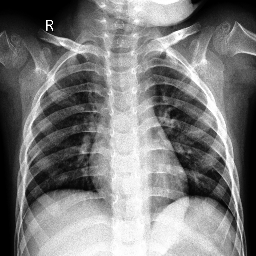

tensor([[-205.4341, 4648.9434, 3587.6885]], grad_fn=<AddmmBackward0>)
Normal


In [ ]:
main()

Training(1) or test(2)?
2
Predict random(1) or specific image(2)?
1


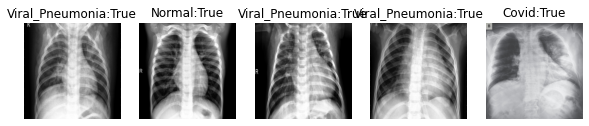

In [ ]:
main()

In [ ]:
1def main():
  print("Training(1) or test(2)?")
  mode=input()
  if mode=="1":
    train()
    print("Training completed")
  else:
    predict()
main()

Training(1) or test(2)?
1
Epoch [0], last_lr: 0.00055, train_loss: 1.1511, val_loss: 9.9674, val_acc: 0.1458
Epoch [1], last_lr: 0.00101, train_loss: 0.3678, val_loss: 1.2324, val_acc: 0.5389
Epoch [2], last_lr: 0.00176, train_loss: 0.2434, val_loss: 0.3800, val_acc: 0.8667
Epoch [3], last_lr: 0.00275, train_loss: 0.3526, val_loss: 0.5126, val_acc: 0.8486
Epoch [4], last_lr: 0.00391, train_loss: 0.4647, val_loss: 0.7971, val_acc: 0.8250
Epoch [5], last_lr: 0.00516, train_loss: 0.4082, val_loss: 1.0962, val_acc: 0.7861
Epoch [6], last_lr: 0.00641, train_loss: 0.3600, val_loss: 2.2389, val_acc: 0.6514
Epoch [7], last_lr: 0.00758, train_loss: 0.5350, val_loss: 10.5116, val_acc: 0.4583
Epoch [8], last_lr: 0.00858, train_loss: 0.6979, val_loss: 6.3861, val_acc: 0.4389
Epoch [9], last_lr: 0.00935, train_loss: 0.3853, val_loss: 51.5966, val_acc: 0.4167
Epoch [10], last_lr: 0.00983, train_loss: 1.3250, val_loss: 13.3777, val_acc: 0.4583
Epoch [11], last_lr: 0.01000, train_loss: 1.0068, val_los

#Training History

In [ ]:
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Epoch [0], last_lr: 0.00055, train_loss: 1.1756, val_loss: 9.8952, val_acc: 0.1458
Epoch [1], last_lr: 0.00101, train_loss: 0.5579, val_loss: 0.5453, val_acc: 0.7486
Epoch [2], last_lr: 0.00176, train_loss: 0.3153, val_loss: 2.6186, val_acc: 0.5847
Epoch [3], last_lr: 0.00275, train_loss: 0.2835, val_loss: 0.7072, val_acc: 0.6931
Epoch [4], last_lr: 0.00391, train_loss: 0.2173, val_loss: 0.4853, val_acc: 0.8014
Epoch [5], last_lr: 0.00516, train_loss: 0.5156, val_loss: 2.6836, val_acc: 0.5653
Epoch [6], last_lr: 0.00641, train_loss: 0.6822, val_loss: 1.8494, val_acc: 0.5167
Epoch [7], last_lr: 0.00758, train_loss: 0.7695, val_loss: 9.9148, val_acc: 0.4375
Epoch [8], last_lr: 0.00858, train_loss: 0.5977, val_loss: 5.4274, val_acc: 0.4792
Epoch [9], last_lr: 0.00935, train_loss: 0.9996, val_loss: 1.7756, val_acc: 0.5750
Epoch [10], last_lr: 0.00983, train_loss: 0.9414, val_loss: 1.4577, val_acc: 0.8236
Epoch [11], last_lr: 0.01000, train_loss: 0.6393, val_loss: 0.3696, val_acc: 0.8694
Ep

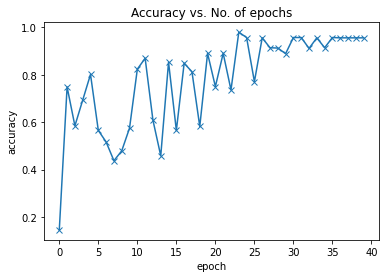

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

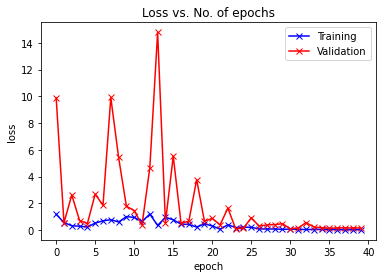

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

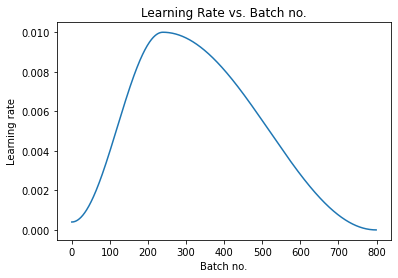

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


plot_lrs(history)